In [150]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [151]:
df = pd.read_csv('../Datasets/nyserda-electric-vehicle-drive-clean-rebate-data-beginning-2017-1.csv')

In [152]:
df

,Data through Date,Submitted Date,Make,Model,County,ZIP,EV Type,Transaction Type,Annual GHG Emissions Reductions (MT CO2e),Annual Petroleum Reductions (gallons),Rebate Amount (USD)
0,02/29/2020,01/13/2018,Ford,Focus,Westchester,10598,BEV,Lease,2.76,592.89,1700
1,02/29/2020,09/25/2017,Ford,Focus,Oneida,13601,BEV,Lease,2.76,592.89,1700
2,02/29/2020,04/26/2018,Ford,Focus,Suffolk,11776,BEV,Lease,2.76,592.89,1700
3,02/29/2020,08/30/2017,Ford,Focus,Nassau,11756,BEV,Lease,2.76,592.89,1700
4,02/29/2020,05/29/2018,Ford,Focus,Onondaga,13039,BEV,Purchase,2.76,592.89,1700
...,...,...,...,...,...,...,...,...,...,...,...
23169,02/29/2020,12/27/2017,Volvo,XC60 T8,Onondaga,13039,PHEV,Purchase,0.40,200.58,500
23170,02/29/2020,05/29/2018,Volvo,XC60 T8,Nassau,11791,PHEV,Purchase,0.40,200.58,500
23171,02/29/2020,09/25/2017,Volvo,XC90 T8,Niagara,14094,PHEV,Purchase,0.68,231.77,500
23172,02/29/2020,11/01/2017,Volvo,XC90 T8,Erie,14051,PHEV,Lease,0.68,231.77,500


In [153]:
df = df.drop(columns=["Data through Date", "ZIP"])

In [154]:
df = df.rename(columns={'Annual GHG Emissions Reductions (MT CO2e)': 'Annual CO2 Reductions', 'Annual Petroleum Reductions (gallons)': 'Annual Petroleum Reductions'})

In [155]:
df

,Submitted Date,Make,Model,County,EV Type,Transaction Type,Annual CO2 Reductions,Annual Petroleum Reductions,Rebate Amount (USD)
0,01/13/2018,Ford,Focus,Westchester,BEV,Lease,2.76,592.89,1700
1,09/25/2017,Ford,Focus,Oneida,BEV,Lease,2.76,592.89,1700
2,04/26/2018,Ford,Focus,Suffolk,BEV,Lease,2.76,592.89,1700
3,08/30/2017,Ford,Focus,Nassau,BEV,Lease,2.76,592.89,1700
4,05/29/2018,Ford,Focus,Onondaga,BEV,Purchase,2.76,592.89,1700
...,...,...,...,...,...,...,...,...,...
23169,12/27/2017,Volvo,XC60 T8,Onondaga,PHEV,Purchase,0.40,200.58,500
23170,05/29/2018,Volvo,XC60 T8,Nassau,PHEV,Purchase,0.40,200.58,500
23171,09/25/2017,Volvo,XC90 T8,Niagara,PHEV,Purchase,0.68,231.77,500
23172,11/01/2017,Volvo,XC90 T8,Erie,PHEV,Lease,0.68,231.77,500


Formatting Date Column

In [156]:
df[['Submitted Month', 'Submitted Year']] = df["Submitted Date"].apply(lambda x: pd.Series([x.split('/')[0], x.split('/')[2]]))

df = df.drop(columns=["Submitted Date", "Submitted Month"])

Label Encoding Categorical Columns

In [157]:
cols = ["Make", "Model", "EV Type","County","Transaction Type", "Rebate Amount (USD)", "Annual CO2 Reductions",	"Annual Petroleum Reductions"]

def label_encode(columns_to_encode):
    for column in columns_to_encode:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

    return df

df = label_encode(cols)

In [158]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Rebate Amount (USD)"])
y = df["Rebate Amount (USD)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [159]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


svc = SVC(kernel='rbf', C=1.0, gamma='auto')

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9936717963469006
Precision: 0.9929875766008778
Recall: 0.9887729032234662
F1 Score: 0.9908175679075677
Confusion Matrix:
[[ 721    0    0   27]
 [   2 2817    2    0]
 [   0    0 1399    4]
 [   3    0    6 1972]]


In [160]:
from sklearn.ensemble import RandomForestClassifier



model = RandomForestClassifier(n_estimators = 30, max_features = 'sqrt', max_depth = 15, random_state = 42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9961167841219617
Precision: 0.9964139393713741
Recall: 0.9911839615383577
F1 Score: 0.9937182825829084
Confusion Matrix:
[[ 722    0    0   26]
 [   0 2821    0    0]
 [   0    0 1403    0]
 [   1    0    0 1980]]


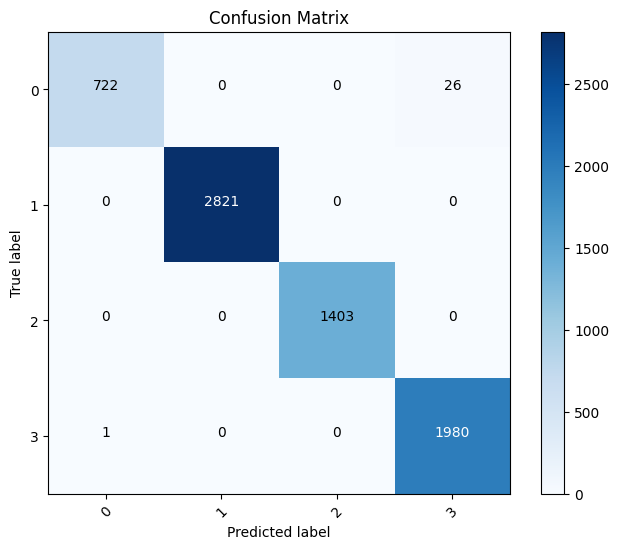

In [161]:

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test))) 
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))

plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()
